# Main Aggregation Script - calls lab.py and crystals.py

In [119]:
#Reloads the lab.py and crystals.py modules to update any changes (after saving)
#If a new method or object is created, autoreload doesn't work and the 
#kernel needs to be closed and halted after saving and making a 'checkpoint'
#in this notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
import ipas 
import numpy as np
import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
from dask import delayed
from dask import dataframe as dd
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import pandas as pd
import time
from dask.distributed import as_completed
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt
import scipy.stats as st


# Load data

In [143]:
f = open('../instance_files/instance_db_aggagg_rand', 'rb')
results = pickle.load(f)
agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds= \
                results['agg_as'], results['agg_bs'], results['agg_cs'], results['phi2Ds'], results['cplxs'], results['dds']
f.close()

f = open('../instance_files/pulled_clusters_aggagg_rand', 'rb')
pulled_clus = pickle.load(f)
f.close()

In [144]:
rand_orient = True      #randomly orient the seed crystal and new crystal: uses first random orientation
agg_phi_bins = 20
agg_r_bins = 20
nclusters = 300

In [145]:
files = [f for f in glob.glob("../instance_files/createdb_iceagg_rand*")]

In [127]:
%%time 
data = []
for file in files:
    print(file)
    data.append(pd.read_pickle(file, None))
datapd = [pd.DataFrame(i) for i in data]
df = pd.concat(datapd, axis=0, ignore_index=True)
df['agg_r'] = np.power((np.power(df['a'], 2) * df['c']), (1./3.))
df['agg_r'] = df['agg_r'][df.agg_r < 5000]
df['shape'] = df.apply(lambda row: 'prolate' if (row.b - row.c) <= (row.a - row.b) else 'oblate', axis=1)
df['agg_phi'] = df.c/df.a

../instance_files/createdb_iceagg_flat_r500_1000
../instance_files/createdb_iceagg_flat_r90_400
../instance_files/createdb_iceagg_flat_r40_80
../instance_files/createdb_iceagg_flat_r10_30
../instance_files/createdb_iceagg_flat_r1_4
../instance_files/createdb_iceagg_flat_r5_9
CPU times: user 7min 1s, sys: 1min 40s, total: 8min 42s
Wall time: 10min 41s


In [132]:
res, phi_bins = pd.qcut(df.agg_phi, 20, retbins=True)
#print(phi_bins)
phi_bin_labs = []
all_r_bins= np.empty((len(phi_bins),len(phi_bins)))
for i in range(agg_phi_bins):
    print('i = ', i)
    phi_bin_labs.append('[%.3f-%.3f]' %(phi_bins[i],phi_bins[i+1]))
    #return a df that only queries within an aspect ratio bin
    df_phi = df[(df.agg_phi > phi_bins[i]) & (df.agg_phi < phi_bins[i+1])]
    #now break that aspect ratio bin into 20 equal r bins
    res, r_bins = pd.qcut(df_phi.agg_r, 20, retbins=True)
    all_r_bins[i,:] = r_bins


i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19


In [133]:
def calculate_error(data, numaspectratios, ch):
    mean = np.mean(data)

    std = np.std(data)
    shape = (mean/std)**2
    scale = (std**2)/mean
    shapech = mean/(numaspectratios*ch)

    pos_error = mean + std
    neg_error = mean - std

    min_data = min(data)
    max_data = max(data)

    return(pos_error, neg_error, min_data, max_data, mean)   

def mode_of_hist(data):
    bins = (np.max(data) - np.min(data))/0.01
    n, bins, patches = plt.hist(data, bins=int(bins), normed=True,
                                color='navy',range=(min(data), max(data)))
    mode = bins[np.where(n == np.max(n))]

    return mode[0]

def fit_distribution(data, normed = True, facecolor='navy', alpha=1.0, axes=None, **kwargs):


    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    data[np.isinf(data)] = min(data)
    data[np.isnan(data)] = min(data)
    data= data[(data<np.quantile(data, .98)) & (data>np.quantile(data, .01))]
    
    # Get histogram of original data
    y, x = np.histogram(data, density=True)
    params = st.gamma.fit(data)
    arg = params[:-2]       

    fit_alpha, fit_loc, fit_beta=st.gamma.fit(data)
    pdf = st.gamma.pdf(x, a=fit_alpha, loc=fit_loc, scale=fit_beta)
    indmax = np.argmax(pdf)  #FIRST index where the highest prob occurs
    gammach_var = x[indmax] #characteristic of the distribution
    if axes is not None:
        n, bins, patches = plt.hist(data, bins=70, normed=True,
                                color='navy',**kwargs)

        ax = plt.plot(x, pdf, lw=5, color='darkorange')
        plt.ylim(0,max(n))
        plt.show()

    return gammach_var

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


-0.01031789184459106
-0.004884124503354403
-0.12053024077580154
-0.12716228471383495
-0.09153496036005393
-0.16042320083763784
-0.07038441292852415
-0.0786682757020154
-0.12317656522842335
-0.01016044006244865
-0.0007754921464235842
-0.004956031620798815
-0.17513460571288242
-0.13652362280035657
-0.007443526202827511
-0.1355417600807569
-0.004230118239158531
-0.1424410253051036
-0.005344554687378711
-0.010697381700521952
-0.010121321078545797
-0.007409442141796063
-0.0050165005925060235
-0.0024909320629551424
-0.0674107393978185
-0.13073154071412574
-0.0938105128333171
-0.08515860458013602
-0.08337735795810053
-0.0026423597393284703
-0.005279049788628143
-0.007065347912517325
-0.00720448291311282
-0.001176814932770942
-0.14195341664696848
-0.0010509811744500164
-0.003836414977344882
-0.0018447405793722282
-0.003342451524527945
-0.004530627849373747
-0.007939468831151153
-0.005105022507486456
-0.006342380601892739
-0.005842240234317675
-0.0014777781649710775
-0.007464185771051124
-0.094

KeyboardInterrupt: 

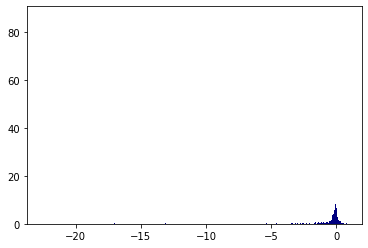

In [142]:
#find characteristic of gamma distribution
numaspectratios=len(agg_as[:,0,0])
numrs=len(agg_bs[0,:,0])
agg_cs_ch = np.empty((numaspectratios, numrs), dtype=np.float64) #major
agg_as_ch = np.empty((numaspectratios, numrs), dtype=np.float64) #minor
agg_as_mean = np.empty((numaspectratios, numrs), dtype=np.float64)
dds_mode = np.empty((numaspectratios, numrs), dtype=np.float64)
# fig = plt.figure(figsize=(5,7))
# ax = plt.subplot(131)

for i in range(numaspectratios):
    for r in range(numrs):
        #print(i,r)
        for c, data in enumerate([agg_cs, agg_as, dds]):

#             if c == 0:
#                 agg_cs_ch[i,r] = fit_distribution(data[i,r,:])
#             if c == 1:
#                 agg_as_ch[i,r] = fit_distribution(data[i,r,:])
#                 _,_,_,_,agg_as_mean[i,r] = calculate_error(data[i,r,:], numaspectratios, agg_as_ch[i,r])
             if c == 2:
#                 #dds_mode[i,r] = fit_distribution(dds[i,r,:], axes=ax)
                dds_mode[i,r] = mode_of_hist(dds[i,r,:])
                print(dds_mode[i,r])


In [135]:
#write to file for output as array:
with open("../lookup_tables/agg_agg/newformat_minorax_ellipsoid_flat_ch_binedges.dat","w") as file1:
    with open("../lookup_tables/agg_agg/newformat_majorax_ellipsoid_flat_ch_binedges.dat","w") as file2:
        with open("../lookup_tables/agg_agg/newformat_majorax_ellipsoid_flat_mean_binedges.dat","w") as file3:
            with open("../lookup_tables/agg_agg/newformat_dd_flat_mode_binedges.dat","w") as file4:

                    file1.write('Agg-Agg collection for the flat orientation. \n'\
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')

                    file2.write('Agg-Agg collection for the flat orientation. \n'
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')

                    file3.write('Agg-Agg collection for the flat orientation. \n'
                                'Mean value taken from the average across 300 aggregates. \n'\
                                'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')
                    
                    file4.write('Agg-Agg collection for the flat orientation. \n'
                                'Avg volume ratio of aggs subtracted from volume ratio of new agg (Vagg/Vellipse)\n'\
                                'Mode from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')


                    for i in range(agg_phi_bins):
                        for r in range(agg_r_bins):
                            listmonophi = [n.monophi for n in pulled_clus[i,r,:]]
                            maxmonophi = max(listmonophi)
                            minmonophi = min(listmonophi)
                            listmonor = [n.monor for n in pulled_clus[i,r,:]]
                            maxmonor = max(listmonor)
                            minmonor = min(listmonor)
                            listaggphi = [n.c/n.a for n in pulled_clus[i,r,:]]
                            maxaggphi = max(listaggphi)
                            minaggphi = min(listaggphi)
                            listaggr = [n.r for n in pulled_clus[i,r,:]]
                            maxaggr = max(listaggr)
                            minaggr = min(listaggr)
                            #print(i,r)
                            file1.write('%.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1], agg_cs_ch[i,r]))
                            file2.write('%.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1], agg_as_ch[i,r]))
                            file3.write('%.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1], agg_as_mean[i,r]))
                            file4.write('%.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1], dds_mode[i,r]))
                                    
file1.close()
file2.close() 
file3.close()
file4.close()

In [20]:
#write to file for output as array:
with open("../lookup_tables/agg_agg/newformat_minorax_ellipsoid_rand_ch_binedges.dat","w") as file1:
    with open("../lookup_tables/agg_agg/newformat_majorax_ellipsoid_rand_ch_binedges.dat","w") as file2:
        with open("../lookup_tables/agg_agg/newformat_majorax_ellipsoid_rand_mean_binedges.dat","w") as file3:
            with open("../lookup_tables/agg_agg/newformat_dd_rand_mode_binedges.dat","w") as file4:

                    file1.write('Agg-Agg collection for the random orientation. \n'\
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')

                    file2.write('Agg-Agg collection for the random orientation. \n'
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')

                    file3.write('Agg-Agg collection for the random orientation. \n'
                                'Mean value taken from the average across 300 aggregates. \n'\
                                'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')
                    
                    file4.write('Agg-Agg collection for the random orientation. \n'
                                'Avg volume ratio of aggs subtracted from volume ratio of new agg (Vagg/Vellipse)\n'\
                                'Mode from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')


                    for i in range(agg_phi_bins):
                        for r in range(agg_r_bins):
                            listmonophi = [n.monophi for n in pulled_clus[i,r,:]]
                            maxmonophi = max(listmonophi)
                            minmonophi = min(listmonophi)
                            listmonor = [n.monor for n in pulled_clus[i,r,:]]
                            maxmonor = max(listmonor)
                            minmonor = min(listmonor)
                            listaggphi = [n.c/n.a for n in pulled_clus[i,r,:]]
                            maxaggphi = max(listaggphi)
                            minaggphi = min(listaggphi)
                            listaggr = [n.r for n in pulled_clus[i,r,:]]
                            maxaggr = max(listaggr)
                            minaggr = min(listaggr)
                            #print(i,r)
                            file1.write('%.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1], agg_cs_ch[i,r]))
                            file2.write('%.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1], agg_as_ch[i,r]))
                            file3.write('%.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1], agg_as_mean[i,r]))
                            file4.write('%.3f %.3f %.3f %.3f %.3f \n' %(phi_bins[i], phi_bins[i+1], all_r_bins[i,r], all_r_bins[i,r+1], dds_mode[i,r]))
                                    
file1.close()
file2.close() 
file3.close()
file4.close()

In [22]:
#write to file for output as array:
with open("../lookup_tables/agg_agg/newformat_minorax_ellipsoid_rand_ch.dat","w") as file1:
    with open("../lookup_tables/agg_agg/newformat_majorax_ellipsoid_rand_ch.dat","w") as file2:
        with open("../lookup_tables/agg_agg/newformat_majorax_ellipsoid_rand_mean.dat","w") as file3:
            with open("../lookup_tables/agg_agg/newformat_dd_rand_mode.dat","w") as file4:

                    file1.write('Agg-Agg collection for the random orientation. \n'\
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')

                    file2.write('Agg-Agg collection for the random orientation. \n'
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')

                    file3.write('Agg-Agg collection for the random orientation. \n'
                                'Mean value taken from the average across 300 aggregates. \n'\
                                'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')
                    
                    file4.write('Agg-Agg collection for the random orientation. \n'
                                'Volume ratio of agg subtracted from volume ratio of new agg (Vagg/Vellipse)\n'\
                                'Mode from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')


                    for i in range(agg_phi_bins):
                        for r in range(agg_r_bins):
                            listmonophi = [n.monophi for n in pulled_clus[i,r,:]]
                            maxmonophi = max(listmonophi)
                            minmonophi = min(listmonophi)
                            listmonor = [n.monor for n in pulled_clus[i,r,:]]
                            maxmonor = max(listmonor)
                            minmonor = min(listmonor)
                            listaggphi = [n.c/n.a for n in pulled_clus[i,r,:]]
                            maxaggphi = max(listaggphi)
                            minaggphi = min(listaggphi)
                            listaggr = [n.r for n in pulled_clus[i,r,:]]
                            maxaggr = max(listaggr)
                            minaggr = min(listaggr)
                            #print(i,r)
                            file1.write('%.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr, agg_cs_ch[i,r]))
                            file2.write('%.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr, agg_as_ch[i,r]))
                            file3.write('%.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr, agg_as_mean[i,r]))
                            file4.write('%.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr, dds_mode[i,r]))
                                    
file1.close()
file2.close() 
file3.close()
file4.close()

In [137]:
#write to file for output as array:
with open("../lookup_tables/agg_agg/newformat_minorax_ellipsoid_flat_ch.dat","w") as file1:
    with open("../lookup_tables/agg_agg/newformat_majorax_ellipsoid_flat_ch.dat","w") as file2:
        with open("../lookup_tables/agg_agg/newformat_majorax_ellipsoid_flat_mean.dat","w") as file3:
            with open("../lookup_tables/agg_agg/newformat_dd_flat_mode.dat","w") as file4:

                    file1.write('Agg-Agg collection for the flat orientation. \n'\
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')

                    file2.write('Agg-Agg collection for the flat orientation. \n'
                                'Characteristic values taken from the peak of a fit \n'\
                                'gamma distribution from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')

                    file3.write('Agg-Agg collection for the flat orientation. \n'
                                'Mean value taken from the average across 300 aggregates. \n'\
                                'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')
                    
                    file4.write('Agg-Agg collection for the flat orientation. \n'
                                'Volume ratio of agg subtracted from volume ratio of new agg (Vagg/Vellipse)\n'\
                                'Mode from 300 aggregates. \n'\
                                'Ranges are taken from the aggregates being pulled from the db, \n' \
                                'not the bin edges (maximum range) \n'\
                                'Order: agg phi min, agg phi max, agg r min, agg r max, value \n')


                    for i in range(agg_phi_bins):
                        for r in range(agg_r_bins):
                            listmonophi = [n.monophi for n in pulled_clus[i,r,:]]
                            maxmonophi = max(listmonophi)
                            minmonophi = min(listmonophi)
                            listmonor = [n.monor for n in pulled_clus[i,r,:]]
                            maxmonor = max(listmonor)
                            minmonor = min(listmonor)
                            listaggphi = [n.c/n.a for n in pulled_clus[i,r,:]]
                            maxaggphi = max(listaggphi)
                            minaggphi = min(listaggphi)
                            listaggr = [n.r for n in pulled_clus[i,r,:]]
                            maxaggr = max(listaggr)
                            minaggr = min(listaggr)
                            #print(i,r)
                            file1.write('%.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr, agg_cs_ch[i,r]))
                            file2.write('%.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr, agg_as_ch[i,r]))
                            file3.write('%.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr, agg_as_mean[i,r]))
                            file4.write('%.3f %.3f %.3f %.3f %.3f \n' %(minaggphi, maxaggphi, minaggr, maxaggr, dds_mode[i,r]))
                                    
file1.close()
file2.close() 
file3.close()
file4.close()